# Traffic Detection Project

* Dataset dataset page: [link to Kaggle Data Card](https://www.kaggle.com/datasets/yusufberksardoan/traffic-detection-project/data)

* Roboflow dataset page [link to Roboflow](https://universe.roboflow.com/fsmvu/street-view-gdogo/dataset/1)

* Download zip from Google Drive: [link](https://drive.google.com/file/d/12e0Av1I1bYjR6JZ23o1YchyYFLorNxX4/view?usp=sharing)


# Data Preparation

## Import libraries

In [2]:
%pip install albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 871.0 kB/s eta 0:00:000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 4.6 MB/s eta 0:00:00
  Using cached typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.6/290.6 kB 7.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 MB 25.5 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.7/431.7 kB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 55.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 633.1/633.1 kB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.2/308.2 kB 19.9 MB/s eta 0:00:00
Using cached typing_extensions-4.12.2-py3-none-any.whl (37 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.11.0
    Uninstallin

In [6]:
import os
import subprocess
import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
from pathlib import Path

## Download and uzip Data 

In [ ]:
filename = "data.zip"
url = "https://www.kaggle.com/api/v1/datasets/download/yusufberksardoan/traffic-detection-project"
extract_dir = "data"  # Directory to extract the zip contents

if os.path.exists(filename):
    print(f"File '{filename}' already exists. Checking for extraction.")
    if os.path.exists(extract_dir) and os.listdir(extract_dir): #Check if already extracted.
        print(f"Directory '{extract_dir}' already exists and is not empty. Skipping extraction.")
    else:
        try:
            subprocess.run(["unzip", "-d", extract_dir, filename], check=True)
            print(f"Successfully extracted '{filename}' to '{extract_dir}'.")
        except subprocess.CalledProcessError as e:
            print(f"Error extracting '{filename}': {e}")
            if os.path.exists(extract_dir):
                import shutil
                shutil.rmtree(extract_dir) #remove corrupted extraction.

else:
    try:
        subprocess.run(["curl", "-L", "-o", filename, url], check=True)
        print(f"Successfully downloaded '{filename}' using curl.")

        try:
            subprocess.run(["unzip", "-d", extract_dir, filename], check=True)
            print(f"Successfully extracted '{filename}' to '{extract_dir}'.")
        except subprocess.CalledProcessError as e:
            print(f"Error extracting '{filename}': {e}")
            if os.path.exists(extract_dir):
                import shutil
                shutil.rmtree(extract_dir) #remove corrupted extraction.
            if os.path.exists(filename):
                os.remove(filename) #remove corrupted zip.

    except subprocess.CalledProcessError as e:
        print(f"Error downloading '{filename}' using curl: {e}")
        if os.path.exists(filename):  # remove corrupted file.
            os.remove(filename)

## Understand Dataset Content

### Number of Files in Each Dataset Split - Bar Graph

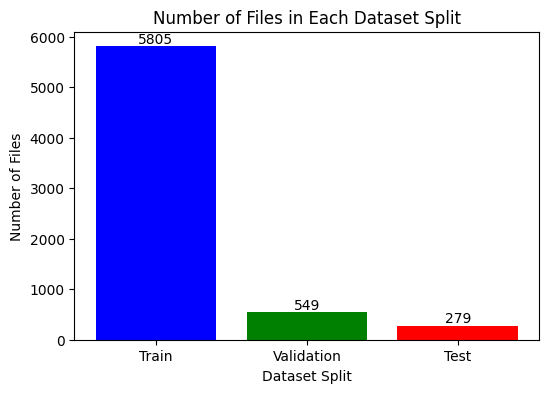

In [5]:
def count_files(directory):
    """
    Count files in the given directory.

    :param directory: directory to analyse
    :return: number of files in the given directory
    """
    count = 0
    for filename in os.listdir(directory):
        if os.path.isfile(os.path.join(directory, filename)):
            count += 1
    return count

# Count images in each folder
train_count = count_files("./data/train/images")
valid_count = count_files("./data/valid/images")
test_count = count_files("./data/test/images")

# Data
categories = ["Train", "Validation", "Test"]
file_counts = [train_count, valid_count, test_count]  # Example values, replace with actual counts if needed

# Plot
plt.figure(figsize=(6, 4))
bars = plt.bar(categories, file_counts, color=["blue", "green", "red"])

# Add labels on top of bars
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             str(int(bar.get_height())), ha="center", va="bottom", fontsize=10)

plt.xlabel("Dataset Split")
plt.ylabel("Number of Files")
plt.title("Number of Files in Each Dataset Split")
plt.show()

### Bounding box count analysis

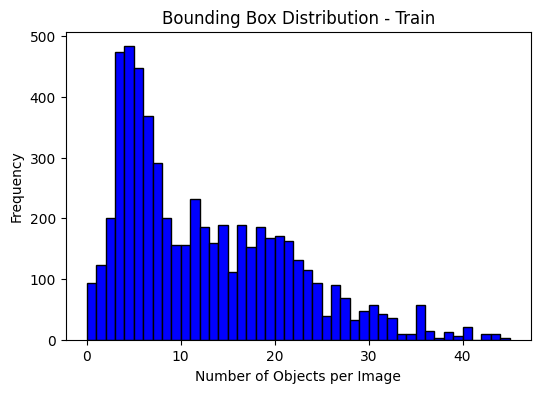

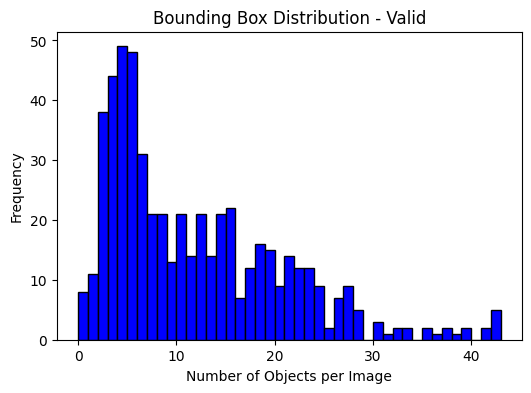

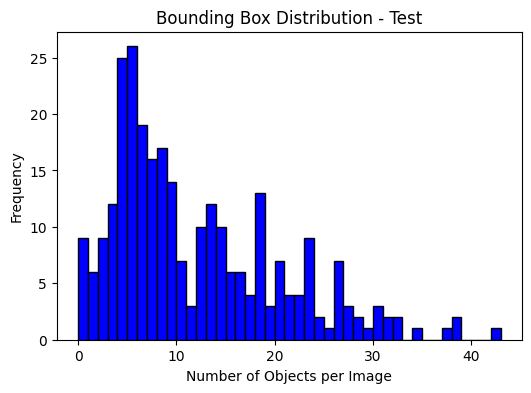

In [7]:
def count_bounding_boxes(label_dir):
    """
    Count the number of bounding boxes per image and overall class distribution.

    :param label_dir: Directory containing YOLO label files
    :return: List of bounding box counts per image, class frequency dictionary
    """
    bbox_counts = []
    class_counts = {}

    for label_file in os.listdir(label_dir):
        if label_file.endswith(".txt"):
            with open(os.path.join(label_dir, label_file), "r") as file:
                lines = file.readlines()
                bbox_counts.append(len(lines))  # Number of objects in the image

                for line in lines:
                    class_id = int(line.split()[0])  # Extract class ID
                    class_counts[class_id] = class_counts.get(class_id, 0) + 1

    return bbox_counts, class_counts


# Define dataset splits
splits = ["train", "valid", "test"]

for split in splits:
    label_dir = f"./data/{split}/labels"
    image_dir = f"./data/{split}/images"

    bbox_counts, class_counts = count_bounding_boxes(label_dir)

    plt.figure(figsize=(6, 4))
    plt.hist(bbox_counts, bins=range(0, max(bbox_counts) + 1), color="blue", edgecolor="black")
    plt.xlabel("Number of Objects per Image")
    plt.ylabel("Frequency")
    plt.title(f"Bounding Box Distribution - {split.capitalize()}")
    plt.show()


### Class distribution analysis

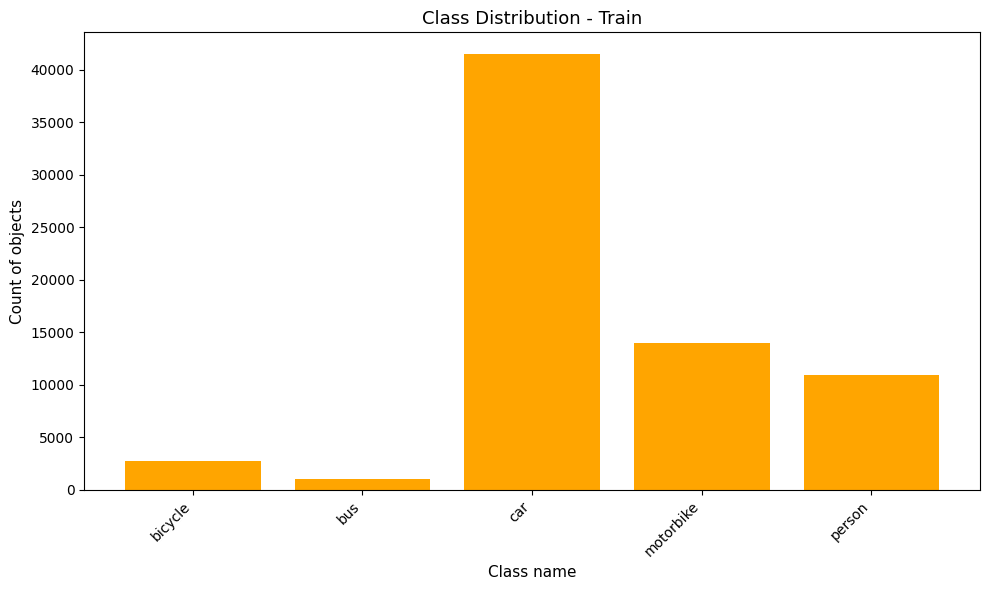

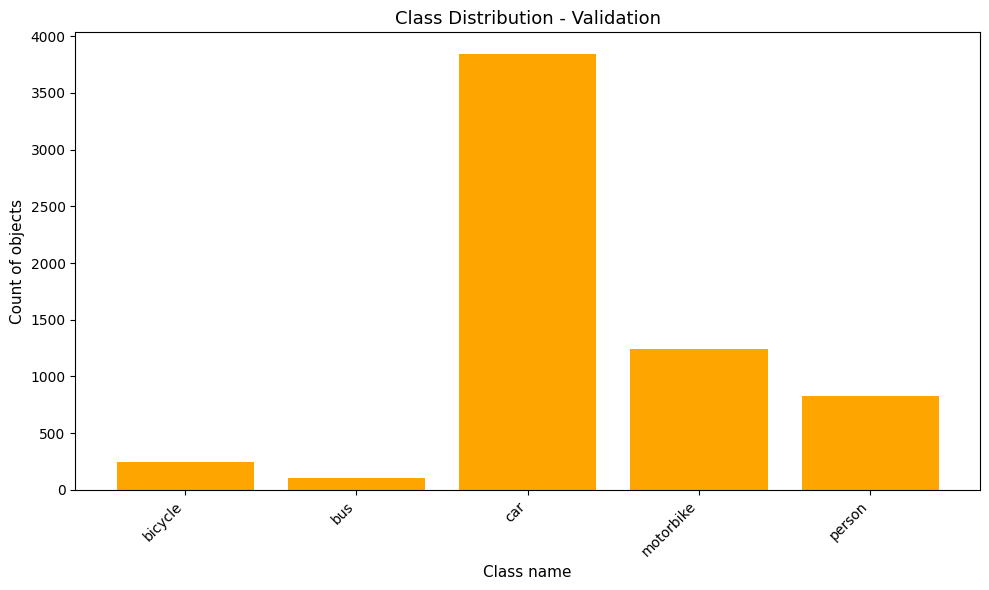

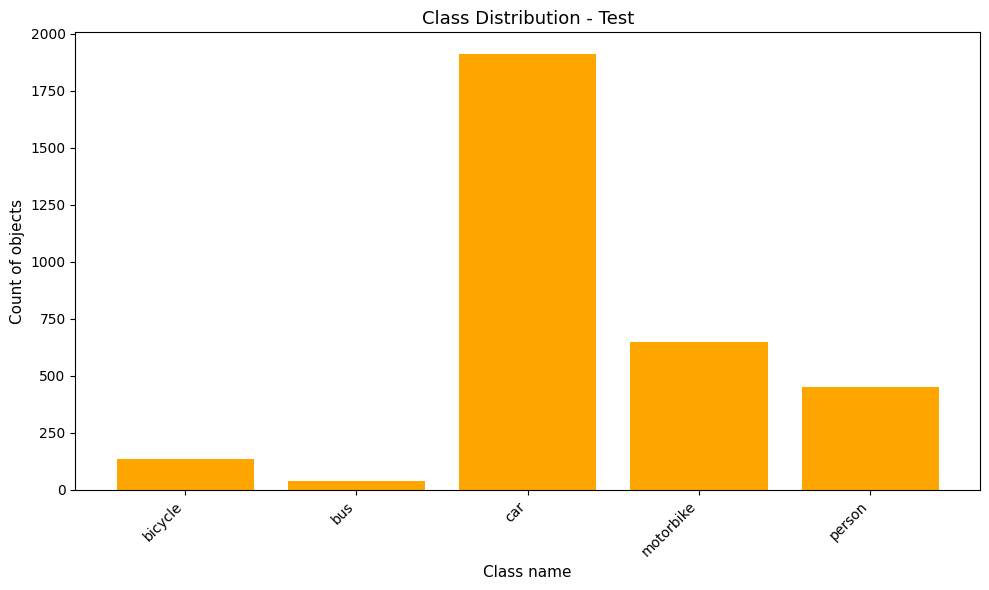

In [9]:
import os
import matplotlib.pyplot as plt

classes = ['bicycle', 'bus', 'car', 'motorbike', 'person']
splits = ['train', 'valid', 'test']  # Add 'test' if you have a test split

for split in splits:
    label_dir = f"./data/{split}/labels"
    image_dir = f"./data/{split}/images"

    class_counts = {i: 0 for i in range(len(classes))}  # Initialize counts for each class

    if os.path.exists(label_dir):
        label_files = [f for f in os.listdir(label_dir) if f.endswith('.txt')]

        for label_file in label_files:
            label_path = os.path.join(label_dir, label_file)
            with open(label_path, 'r') as f:
                for line in f:
                    class_id = int(line.split()[0])  # Get the class ID from the first element
                    if class_id in class_counts:
                        class_counts[class_id] += 1
                    else:
                        print(f"Warning: Class ID {class_id} found in {label_file} but not in classes list.")

        # Class distribution analysis
        plt.figure(figsize=(10, 6))  # Increased figsize for better readability
        plt.bar(class_counts.keys(), class_counts.values(), color="orange")
        plt.xlabel("Class name", fontsize=11)
        plt.ylabel("Count of objects", fontsize=11) #changed to object, as we are counting objects not images.

        if split == "valid":
            plt.title(f"Class Distribution - {"validation".capitalize()}", fontsize=13)
        else:
            plt.title(f"Class Distribution - {split.capitalize()}", fontsize=13)

        # Map class IDs to class names for x-axis labels
        class_labels = [classes[cid] if cid < len(classes) else f"Class {cid}" for cid in class_counts.keys()]
        plt.xticks(list(class_counts.keys()), class_labels, rotation=45, ha='right')  # Rotate labels for better readability

        plt.tight_layout() #prevents overlapping.
        plt.show()
    else:
        print(f"Warning: Label directory {label_dir} not found for {split} split.")

### Image size visualization

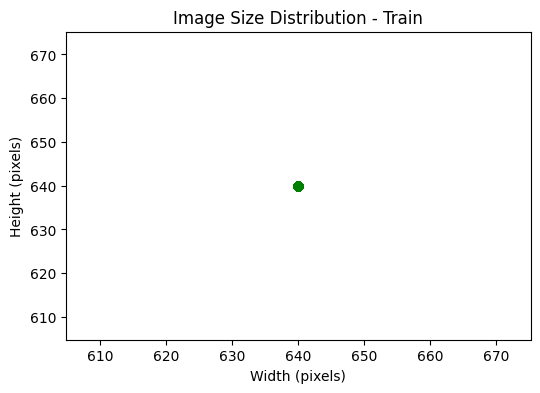


Split: train
width: {640}px
height: {640}px



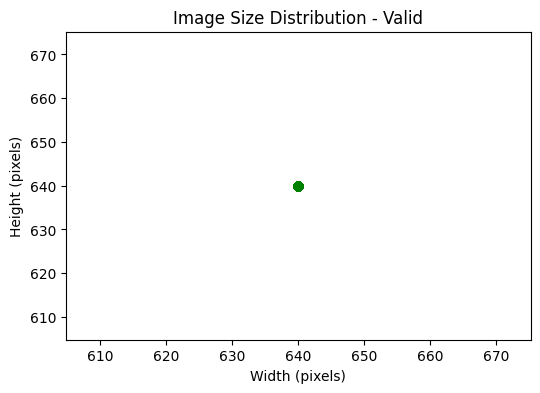


Split: valid
width: {640}px
height: {640}px



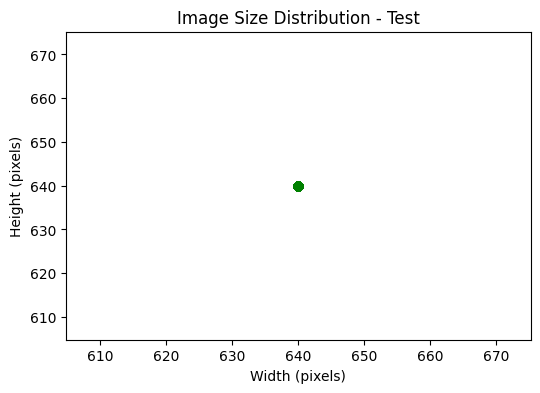


Split: test
width: {640}px
height: {640}px



In [10]:
def get_image_sizes(image_dir):
    """
    Get image dimensions (width, height) for visualization.

    :param image_dir: Directory containing images
    :return: List of (width, height) tuples
    """
    image_sizes = []

    for image_file in os.listdir(image_dir):
        if image_file.endswith((".jpg", ".png")):
            image_path = os.path.join(image_dir, image_file)
            image = cv2.imread(image_path)
            if image is not None:
                h, w, _ = image.shape
                image_sizes.append((w, h))

    return image_sizes

for split in splits:
    label_dir = f"./data/{split}/labels"
    image_dir = f"./data/{split}/images"

    image_sizes = get_image_sizes(image_dir)
    widths, heights = zip(*image_sizes) if image_sizes else ([], [])

    plt.figure(figsize=(6, 4))
    plt.scatter(widths, heights, alpha=0.5, color="green")
    plt.xlabel("Width (pixels)")
    plt.ylabel("Height (pixels)")
    plt.title(f"Image Size Distribution - {split.capitalize()}")
    plt.show()

    print(f"\nSplit: {split}")
    print(f"width: {set(widths)}px")
    print(f"height: {set(heights)}px")
    print()


### Visualise sample data - images with YOLO labels (bounding boxes)


Displaying sample images from train set:


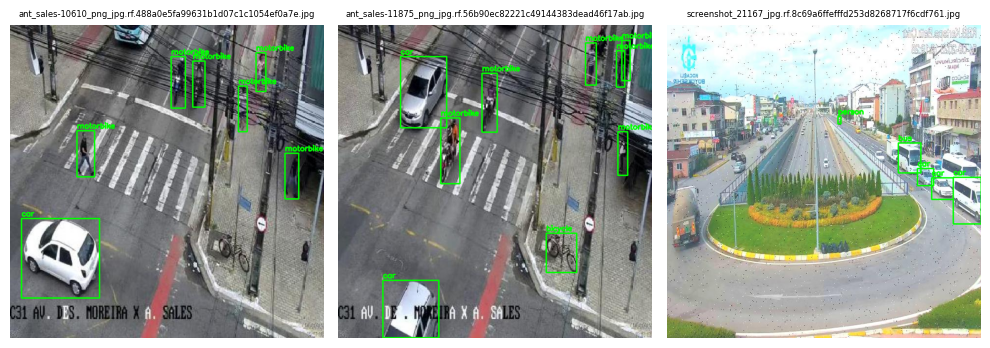


Displaying sample images from valid set:


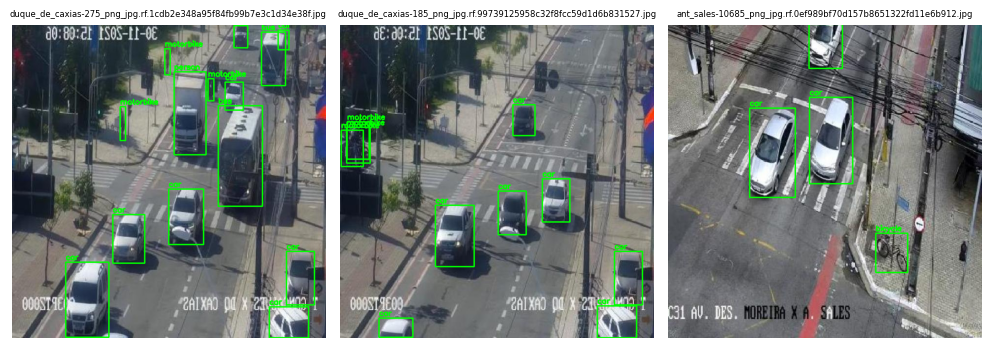


Displaying sample images from test set:


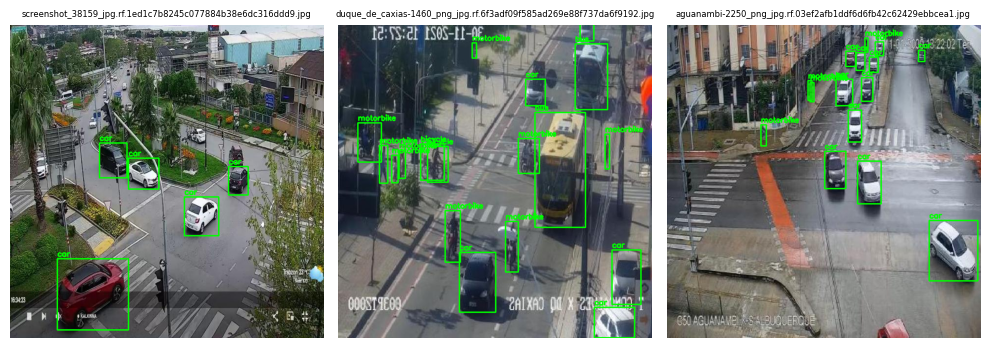

In [11]:
# Function to read YOLO label files and extract bounding boxes
def read_yolo_labels(label_path, img_width, img_height):
    """
    Reads YOLO-format labels and returns bounding box coordinates.

    :param label_path: Path to the .txt label file
    :param img_width: Image width
    :param img_height: Image height
    :return: List of bounding boxes [(class_id, x_min, y_min, x_max, y_max)]
    """
    bboxes = []

    with open(label_path, "r") as file:
        for line in file.readlines():
            data = line.strip().split()
            class_id = int(data[0])
            x_center, y_center, bbox_width, bbox_height = map(float, data[1:])

            # Convert YOLO format to pixel coordinates
            x_min = int((x_center - bbox_width / 2) * img_width)
            y_min = int((y_center - bbox_height / 2) * img_height)
            x_max = int((x_center + bbox_width / 2) * img_width)
            y_max = int((y_center + bbox_height / 2) * img_height)

            bboxes.append((class_id, x_min, y_min, x_max, y_max))

    return bboxes

# Function to plot images with bounding boxes
def plot_sample_images(image_dir, label_dir, num_samples=3):
    """
    Randomly selects images, draws bounding boxes, and plots them.

    :param image_dir: Directory containing images
    :param label_dir: Directory containing corresponding YOLO labels
    :param num_samples: Number of images to display
    """
    image_files = [f for f in os.listdir(image_dir) if f.endswith((".jpg", ".png"))]

    # Randomly select images
    selected_images = random.sample(image_files, min(num_samples, len(image_files)))

    plt.figure(figsize=(10, 5))

    for i, image_file in enumerate(selected_images):
        img_path = os.path.join(image_dir, image_file)
        label_path = os.path.join(label_dir, image_file.replace(".jpg", ".txt").replace(".png", ".txt"))

        # Load image
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        img_height, img_width, _ = image.shape

        # Read labels
        if os.path.exists(label_path):
            bboxes = read_yolo_labels(label_path, img_width, img_height)

            # Draw bounding boxes
            for class_id, x_min, y_min, x_max, y_max in bboxes:
                color = (0, 255, 0)  # Green box
                cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color, 2)

                # Add class label
                label = classes[class_id] if class_id < len(classes) else f"Class {class_id}"
                cv2.putText(image, label, (x_min, y_min - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        # Plot image
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(image)
        plt.axis("off")
        plt.title(image_file, fontsize=6)

    plt.tight_layout()
    plt.show()

for split in splits:
    image_dir = f"./data/{split}/images"
    label_dir = f"./data/{split}/labels"

    print(f"\nDisplaying sample images from {split} set:")
    plot_sample_images(image_dir, label_dir, num_samples=3)


# Data Augmentation

In [4]:
%pip install albumentations

Note: you may need to restart the kernel to use updated packages.


In [9]:
# Adjusted augmentation pipeline
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=10, p=0.6),  # Reduced rotation
    A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.3),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),
    A.Blur(blur_limit=3, p=0.1),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

def augment_data(images_dir, labels_dir, output_images_dir, output_labels_dir, num_augmentations=3):
    """Augments images and labels using Albumentations."""
    os.makedirs(output_images_dir, exist_ok=True)
    os.makedirs(output_labels_dir, exist_ok=True)

    image_files = [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

    for image_file in image_files:
        image_path = os.path.join(images_dir, image_file)
        label_path = os.path.join(labels_dir, image_file.replace(os.path.splitext(image_file)[1], '.txt'))
        output_image_base = os.path.splitext(image_file)[0]

        image = cv2.imread(image_path)
        if image is None:
            print(f"Error: Could not read image {image_path}")
            continue

        h, w, _ = image.shape
        bboxes = []
        class_labels = []

        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    class_id, center_x, center_y, bbox_width, bbox_height = map(float, line.split())
                    bboxes.append([center_x, center_y, bbox_width, bbox_height])
                    class_labels.append(int(class_id))

        for i in range(num_augmentations):
            augmented = transform(image=image, bboxes=bboxes, class_labels=class_labels)
            augmented_image = augmented['image']
            augmented_bboxes = augmented['bboxes']
            augmented_class_labels = augmented['class_labels']

            output_image_file = f"{output_image_base}_aug_{i}.jpg"
            output_label_file = f"{output_image_base}_aug_{i}.txt"
            cv2.imwrite(os.path.join(output_images_dir, output_image_file), augmented_image)

            with open(os.path.join(output_labels_dir, output_label_file), 'w') as f:
                for bbox, class_label in zip(augmented_bboxes, augmented_class_labels):
                    center_x, center_y, bbox_width, bbox_height = bbox
                    f.write(f"{class_label} {center_x} {center_y} {bbox_width} {bbox_height}\n")

# Example usage (augment training data):
train_images_dir = "./data/train/images"
train_labels_dir = "./data/train/labels"
output_train_images_dir = "./data/train/augmented_images"
output_train_labels_dir = "./data/train/augmented_labels"

augment_data(train_images_dir, train_labels_dir, output_train_images_dir, output_train_labels_dir, num_augmentations=3)

### Plot original vs. augmented images

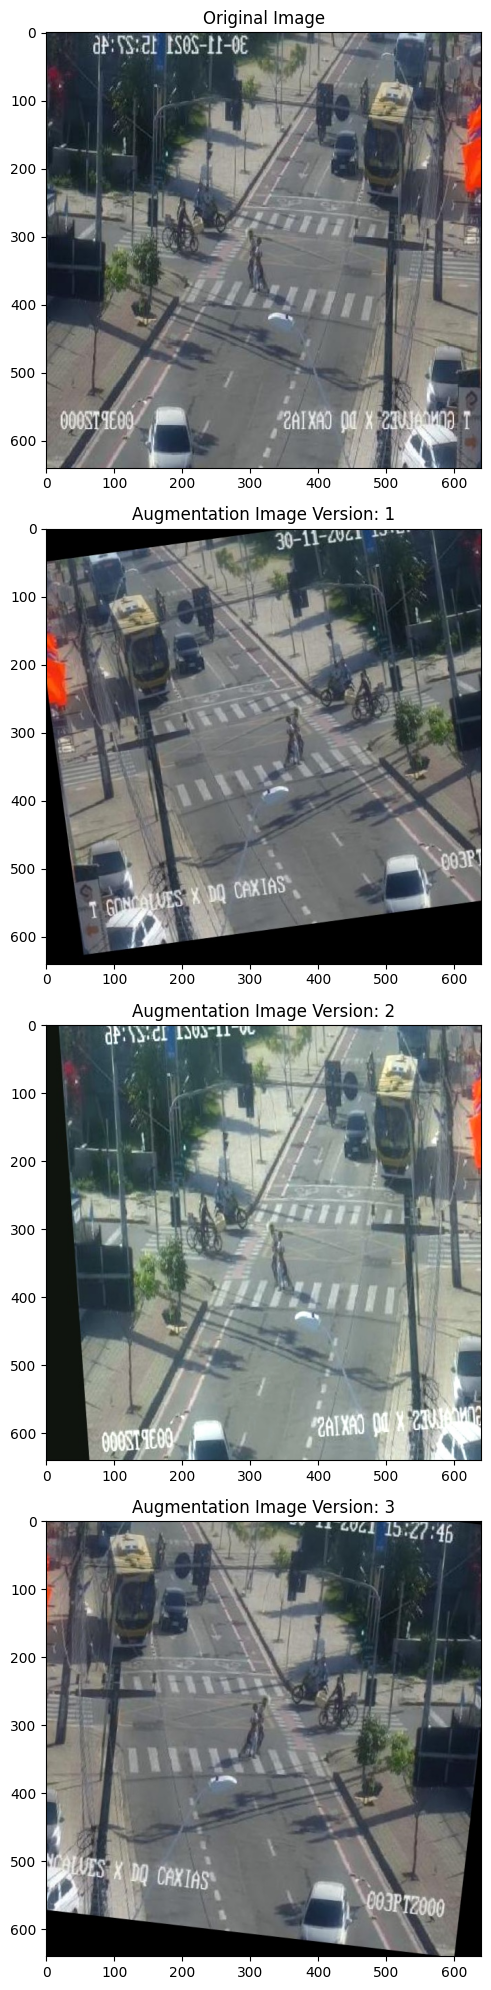

In [10]:
import os
import cv2
import matplotlib.pyplot as plt

def plot_all_augmentations(original_images_dir, original_labels_dir, augmented_images_dir, num_augmentations=3):
    """Plots original and all augmented images for a single original image."""
    original_image_files = [f for f in os.listdir(original_images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

    if not original_image_files:
        print("No original images found.")
        return

    original_image_file = original_image_files[0]  # Take the first image.

    original_image_path = os.path.join(original_images_dir, original_image_file)
    original_label_path = os.path.join(original_labels_dir, original_image_file.replace(os.path.splitext(original_image_file)[1], '.txt'))

    original_image = cv2.imread(original_image_path)
    if original_image is None:
        print(f"Error: Could not read original image {original_image_path}")
        return

    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(15, 5 * (num_augmentations + 1)))  # Adjust figure size

    plt.subplot(num_augmentations + 1, 1, 1)
    plt.imshow(original_image)
    plt.title("Original Image")

    for i in range(num_augmentations):
        augmented_image_file = f"{os.path.splitext(original_image_file)[0]}_aug_{i}.jpg"
        augmented_image_path = os.path.join(augmented_images_dir, augmented_image_file)

        augmented_image = cv2.imread(augmented_image_path)
        if augmented_image is None:
            print(f"Warning: Could not read augmented image {augmented_image_path}")
            continue

        augmented_image = cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB)

        plt.subplot(num_augmentations + 1, 1, i + 2)
        plt.imshow(augmented_image)
        plt.title(f"Augmentation Image Version: {str(i+1)}")

    plt.tight_layout() #prevents overlapping titles.
    plt.show()

# Example usage:
original_images_dir = "./data/train/images"
original_labels_dir = "./data/train/labels"
augmented_images_dir = "./data/train/augmented_images"

plot_all_augmentations(original_images_dir, original_labels_dir, augmented_images_dir, num_augmentations=3)

In [28]:
%cd ..

/home/student/184698


In [32]:
!ls yolov5

benchmarks.py	 data	     LICENSE	     README.zh-CN.md   tutorial.ipynb
CITATION.cff	 detect.py   models	     requirements.txt  utils
classify	 export.py   pyproject.toml  segment	       val.py
CONTRIBUTING.md  hubconf.py  README.md	     train.py


# Training

## Trainig using original data (without augmentations)

In [16]:
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5
%pip install -r requirements.txt


Cloning into 'yolov5'...
remote: Enumerating objects: 17274, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 17274 (delta 1), reused 0 (delta 0), pack-reused 17270 (from 3)
Receiving objects: 100% (17274/17274), 16.12 MiB | 23.83 MiB/s, done.
Resolving deltas: 100% (11862/11862), done.
/home/student/184698/yolov5
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.6/207.6 kB 3.6 MB/s eta 0:00:00a 0:00:01
Using cached requests-2.32.3-py3-none-any.whl (64 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 3.8 MB/s eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.65.0
    Uninstalling tqdm-4.65.0:
      Successfully uninstalled tqd

In [35]:
%pwd


'/home/student/184698'

In [36]:
%ls

data/  data.zip  Traffic_Detection_with_YOLO.ipynb  yolov5/


In [37]:
%ls yolov5/runs/train

ls: cannot access 'yolov5/runs/train': No such file or directory


In [39]:
%pip install tensorboard

  Using cached tensorboard_data_server-0.7.2-py3-none-manylinux_2_31_x86_64.whl.metadata (1.1 kB)
  Using cached werkzeug-3.1.3-py3-none-any.whl.metadata (3.7 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 12.4 MB/s eta 0:00:0000:0100:01
Using cached tensorboard_data_server-0.7.2-py3-none-manylinux_2_31_x86_64.whl (6.6 MB)
Using cached werkzeug-3.1.3-py3-none-any.whl (224 kB)
Note: you may need to restart the kernel to use updated packages.


In [54]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [55]:
%reload_ext tensorboard

In [56]:
# in the command line use this command and open localhost:6006 to see TensorBoard: tensorboard --logdir yolov5/runs/train

In [57]:
%tensorboard --logdir yolov5/runs/train

Reusing TensorBoard on port 6007 (pid 100204), started 0:19:31 ago. (Use '!kill 100204' to kill it.)

The *data/data.yaml* file look sliek this:
```
train: ../data/train/images
val: ../data/valid/images
test: ../data/test/images

nc: 5
names: ['bicycle', 'bus', 'car', 'motorbike', 'person']

roboflow:
  workspace: fsmvu
  project: street-view-gdogo
  version: 1
  license: CC BY 4.0
  url: https://universe.roboflow.com/fsmvu/street-view-gdogo/dataset/1
```

In [12]:
# Check CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [13]:
# Ensure the dataset YAML path is correct
DATA_YAML = str(Path("data/data.yaml").resolve())  # Get absolute path

# Define training parameters
MODEL = "yolov5s"
EPOCHS = 50
BATCH_SIZE = 60
IMG_SIZE = 640
# Run training
!python yolov5/train.py --img {IMG_SIZE} --batch {BATCH_SIZE} --epochs {EPOCHS} --data {DATA_YAML} --weights {MODEL}.pt --device 0 --cache

train: weights=yolov5s.pt, cfg=, data=/home/student/184698/data/data.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=60, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=yolov5/data/hyps, resume_evolve=None, bucket=, cache=ram, image_weights=False, device=0, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
Command 'git fetch origin' timed out after 5 seconds
YOLOv5 🚀 v7.0-399-g8cc44963 Python-3.12.2 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce RTX 4070 Ti, 11987MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warm

## Testing trained model

In [14]:
trained_model_directory = "exp11"

# Define paths
MODEL_WEIGHTS = Path(f"yolov5/runs/train/{trained_model_directory}/weights/best.pt").resolve()
DATA_bYAML = Path("data/data.yaml").resolve()
RESULTS_DIR = Path("yolov5/runs/test/yolo_det").resolve()  # Output directory for test results

# Run YOLOv5 test
!python yolov5/val.py --weights {MODEL_WEIGHTS} --data {DATA_YAML} --task test --name yolo_det --project {RESULTS_DIR}


val: data=/home/student/184698/data/data.yaml, weights=['/home/student/184698/yolov5/runs/train/exp11/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=/home/student/184698/yolov5/runs/test/yolo_det, name=yolo_det, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-399-g8cc44963 Python-3.12.2 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce RTX 4070 Ti, 11987MiB)

Fusing layers... 
Model summary: 157 layers, 7023610 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning /home/student/184698/data/test/labels.cache... 279 images, 9 back
                 Class     Images  Instances          P          R      mAP50   
                   all        279       3188      0.941      0.903      0.948      0.721
               bicycle        279        134      0.973      0.948      0.981      0.795
             

## Hyperparamter tuning

In [15]:
!python yolov5/train.py --img {IMG_SIZE} --batch {BATCH_SIZE} --epochs {EPOCHS} --data {DATA_YAML} --weights {MODEL}.pt --device 0 --cache --evolve 20

train: weights=yolov5s.pt, cfg=, data=/home/student/184698/data/data.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=60, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=20, evolve_population=yolov5/data/hyps, resume_evolve=None, bucket=, cache=ram, image_weights=False, device=0, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
Command 'git fetch origin' timed out after 5 seconds
YOLOv5 🚀 v7.0-399-g8cc44963 Python-3.12.2 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce RTX 4070 Ti, 11987MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup

## Train YOLOv5 using augmented data

The *data/data_aug.yaml* file look sliek this:
```
train:
  - ../data/train/images
  - ../data/train/augmented_images
val: ../data/valid/images
test: ../data/test/images

nc: 5
names: ['bicycle', 'bus', 'car', 'motorbike', 'person']

roboflow:
  workspace: fsmvu
  project: street-view-gdogo
  version: 1
  license: CC BY 4.0
  url: https://universe.roboflow.com/fsmvu/street-view-gdogo/dataset/1
```

In [70]:
!pwd

/home/student/184698


In [76]:
!ls

data  data.zip	Traffic_Detection_with_YOLO.ipynb  yolov5  yolov5s.pt


In [79]:
!cat yolov5/runs/evolve/exp3/hyp_evolve.yaml

# YOLOv5 Hyperparameter Evolution Results
# Best generation: 2
# Last generation: 6
#    metrics/precision,       metrics/recall,      metrics/mAP_0.5, metrics/mAP_0.5:0.95,         val/box_loss,         val/obj_loss,         val/cls_loss
#              0.92479,               0.8982,              0.93642,              0.68393,             0.027604,             0.040704,             0.001621

lr0: 0.01
lrf: 0.01
momentum: 0.937
weight_decay: 0.0005
warmup_epochs: 3.0
warmup_momentum: 0.8
warmup_bias_lr: 0.1
box: 0.05
cls: 0.5
cls_pw: 1.0
obj: 1.0
obj_pw: 1.0
iou_t: 0.2
anchor_t: 4.0
fl_gamma: 0.0
hsv_h: 0.0188
hsv_s: 0.704
hsv_v: 0.36
degrees: 0.0
translate: 0.0902
scale: 0.491
shear: 0.0
perspective: 0.0
flipud: 0.0
fliplr: 0.5
mosaic: 1.0
mixup: 0.0
copy_paste: 0.0
anchors: 3.0


In [1]:
from pathlib import Path

# Ensure the dataset YAML path is correct
DATA_YAML = str(Path("data/data_aug.yaml").resolve())

# Define training parameters

# Use hyp_evolved.yaml for evolved hyperparameters
trained_model_directory = "exp4"
# HYP_EVOLVED_YAML = f"yolov5/runs/evolve/{trained_model_directory}/hyp_evolved.yaml"
HYP_EVOLVED_YAML = str(Path(f"yolov5/runs/evolve/{trained_model_directory}/hyp_evolve.yaml").resolve())  # Get absolute path

# If you want to start from pretrained weights, use this, otherwise use ''
MODEL_WEIGHTS = "yolov5s.pt" # or '' if you do not want to use pretrained weights.

EPOCHS = 50
BATCH_SIZE = 40
IMG_SIZE = 640

print(f"using hyperparameters: {HYP_EVOLVED_YAML}")
print(f"using weights: {MODEL_WEIGHTS}")

# Run training
!python yolov5/train.py --img {IMG_SIZE} --batch {BATCH_SIZE} --epochs {EPOCHS} --data {DATA_YAML} --weights {MODEL_WEIGHTS} --hyp {HYP_EVOLVED_YAML} --device 0 --cache

using hyperparameters: /home/student/184698/yolov5/runs/evolve/exp4/hyp_evolve.yaml
using weights: yolov5s.pt
train: weights=yolov5s.pt, cfg=, data=/home/student/184698/data/data_aug.yaml, hyp=/home/student/184698/yolov5/runs/evolve/exp4/hyp_evolve.yaml, epochs=50, batch_size=40, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=yolov5/data/hyps, resume_evolve=None, bucket=, cache=ram, image_weights=False, device=0, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
Command 'git fetch origin' timed out after 5 seconds
YOLOv5 🚀 v7.0-399-g8cc44963 Python-3.12.2 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce RTX 4

## Testing the model trained with augmented data
Remember to change the variable with the experiment number to select the correct model

In [2]:

model_trained_with_augmented_data_directory = "exp14"
# Define paths
MODEL_WEIGHTS = Path(f"yolov5/runs/train/{trained_model_directory}/weights/best.pt").resolve()  # use best HPs from evolve directory
DATA_YAML = Path("data/data_aug.yaml").resolve()
RESULTS_DIR = Path("yolov5/runs/test/augmented_model_testing2").resolve()  # Output directory for test results

# Run YOLOv5 test
!python yolov5/val.py --weights {MODEL_WEIGHTS} --data {DATA_YAML} --task test --name yolo_det --project {RESULTS_DIR}


val: data=/home/student/184698/data/data_aug.yaml, weights=['/home/student/184698/yolov5/runs/train/exp15/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=/home/student/184698/yolov5/runs/test/augmented_model_testing2, name=yolo_det, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-399-g8cc44963 Python-3.12.2 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce RTX 4070 Ti, 11987MiB)

Fusing layers... 
Model summary: 157 layers, 7023610 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning /home/student/184698/data/test/labels.cache... 279 images, 9 back
                 Class     Images  Instances          P          R      mAP50   
                   all        279       3188      0.937      0.901      0.943       0.71
               bicycle        279        134      0.976       0.94      0.977     